# Code zum Artikel "Eine Einführung in scikit-learn"

Dieses Notebook enthält einen (verkürzt dargestellten) Workflow zur Datenvorverarbeitung und Entwicklung eines Regressionsmodells zur Vorhersage von Gebrauchtwagenpreisen.

In [2]:
import pandas as pd
import datetime
import plotly_express as px
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
)
import shap

pd.options.plotting.backend = "plotly"


/Users/alinadallmann/opt/anaconda3/envs/challenge3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# definition of some colors for plots
COLORS = [
    "#2f4463",
    "#04bfbf",
    "#89cff0",
    "#4d42bf"]

## Laden der Daten / Datenbereinigung
*   Laden einer csv-Datei mit Daten zu gebrauchten Autos (Quelle: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)
*   Löschen der Datensatzspalten, die für das Problem irrelevant sind
*   Auswahl eines Subdatensatzes
    * nur die 15 meistverkauften Modelle
    * ohne Outlier

In [4]:
# load data
data_file = "./data/vehicles.csv"
df = pd.read_csv(data_file)

In [5]:
# drop unwanted columns
drop_cols = [
    "id",
    "url",
    "region",
    "region_url",
    "image_url",
    "description",
    "county",
    "state",
    "VIN",
    "posting_date",
    "title_status",
    "lat",
    "long",
]
df = df.drop(columns=drop_cols, errors="ignore")


In [6]:
# exemplary data excerpt
df[30004:30009]

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
30004,5500,2006.0,honda,accord,excellent,6 cylinders,gas,136000.0,automatic,fwd,full-size,sedan,silver
30005,5000,2000.0,mercedes-benz,benz e430,good,8 cylinders,gas,98000.0,automatic,rwd,mid-size,sedan,black
30006,6100,1999.0,subaru,forester,excellent,4 cylinders,gas,123000.0,automatic,4wd,mid-size,SUV,green
30007,6900,2007.0,lexus,gs350,good,6 cylinders,gas,208000.0,automatic,rwd,mid-size,sedan,white
30008,9000,2012.0,kia,optima,excellent,4 cylinders,gas,88205.0,automatic,rwd,full-size,sedan,silver


In [7]:
# delete duplicated values
old_length = len(df)
df = df[~df.duplicated()]
new_length = len(df)

print(f"The number of rows was reduced from {old_length} to {new_length}")

The number of rows was reduced from 426880 to 248234


In [8]:
# take only x (20) most used models
num_models = 20
most_used_models = df["model"].value_counts()[:num_models].index.to_list()
df = df[df.model.isin(most_used_models)]
df = df.drop(columns=["model"])

In [9]:
px.histogram(df[df.price < 100000], x="price", title="Price histogram before cleaning prices")

In [10]:
# delete rather rare prices and too unrealistic prices
df = df[df.price < 50000]
df = df[df.price > 200]

In [11]:
px.histogram(df, x="price", title="Price histogram after cleaning prices")

In [12]:
# delete unrealistic prices for unknown conditions?
df = df[~((df.price < 1000) & ~(df.condition.isna()))]

# unrealistic kilometers (too high) and too low (as cars should be used cars)
df = df[(df.odometer < 300000) & (df.odometer > 500)]

In [13]:
px.histogram(df, x="odometer", title="Odometer histogram after cleaning odometer data")

In [14]:
print(f"The cleaned dataframe contains {len(df)} rows")

The cleaned dataframe contains 32771 rows


## Datenvorverarbeitung
- One-Hot-Encoding der Kategoriespalten
- Berechnung des Alters eines Autos

In [15]:
category_cols = [
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
]

In [16]:
# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["price"]), df["price"], test_size=0.2, random_state=42
)

In [17]:
# define data preprocessing steps and combine them into a ColumnTransformer
one_hot_encoder = OneHotEncoder(
    dtype=int, handle_unknown="infrequent_if_exist", sparse_output=False
)
age_calculator = FunctionTransformer(
    lambda x: datetime.date.today().year - x, feature_names_out="one-to-one"
)
column_transformer = make_column_transformer(
    (one_hot_encoder, category_cols),
    (age_calculator, ["year"]),
    ("passthrough", ["odometer"]),
    verbose_feature_names_out=False,
).set_output(transform="pandas")


In [18]:
# create train features using previously defined steps
train_features = column_transformer.fit_transform(X_train)
train_features.head()


,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_jeep,manufacturer_nissan,manufacturer_ram,manufacturer_toyota,manufacturer_nan,...,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,paint_color_nan,year,odometer
256221,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,15.0,98992.0
264946,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,18.0,106297.0
158906,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,11.0,97646.0
242893,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,18.0,256000.0
28242,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,15.0,114563.0


Die Trainingsdaten enthalten mehr Spalten als die Ausgangsdaten, da für jede Kategorie einer Kategoriespalte mit dem OneHotEncoding eine separate Spalte erstellt wurde

## Feature-Auswahl und Modelltraining
- Auswahl der 15 besten Features, anhand der Metrik "mutual info regression"
- Training der gesamten Pipeline: Datenvorverarbeitung, Featureauswahl, Training eines Regressionsalgorithmus

In [19]:
# define feature selector and full pipeline containing preprocessing and algorithm
feature_selector = SelectKBest(mutual_info_regression, k=15).set_output(
    transform="pandas"
)
pipe = Pipeline(
    [
        ("column_transformer", column_transformer),
        ("column_selection", feature_selector),
        ("model", GradientBoostingRegressor(random_state=2)),
    ]
)

In [20]:
# Display Pipeline
set_config(display="diagram")

# fit data
pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x7f7ce9ff37f0>),
                                                  ['year']),
                                                 ('passthrough', 'passthrough',
                                                  ['odometer'])],
                                   verbose_feature_names_out=False)),
                ('column_selection',
                 SelectKBest(k=15,
                             score_func=<function mutual_info_regression at 0x7f7d88e56830>)),
                ('model', GradientBoostingRegressor(random_state=2))])

In [21]:
y_pred = pipe.predict(X_test)
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred)}")

Mean absolute error: 3838.610848259161


### Kreuzvalidierung

In [22]:
cv_result = cross_validate(pipe, X_train, y_train, cv=10,
						   scoring="neg_mean_absolute_error", return_estimator=True)

In [23]:
cv_result["test_score"]

array([-3929.9280135 , -3993.93570542, -3744.74711023, -3940.86212574,
       -3883.47615182, -3882.64423588, -3865.1318849 , -3892.95369831,
       -3927.01482431, -3895.27635233])

In [24]:
cv_result["test_score"].mean()

-3895.5970102447254

Der Fehler ist hier etwas höher als bei der vorherigen Pipeline. Dies macht jedoch Sinn, da jeweils nicht auf den vollständigen Trainingsdaten trainiert wurde. Vorteilhaft bei der Kreuzvalidierung ist jedoch, dass das Risiko von Overfitting bei der Modellauswahl vermindert wird

In [25]:
# take the 8th model and get an idea of the error using the test set
y_pred_cv = cv_result["estimator"][7].predict(X_test)
mean_absolute_error(y_test, y_pred_cv)

3827.353055765721

### Interpretation der Modellergebnisse

In [26]:
# get feature names of features which got selected
feature_names = pipe[1].get_feature_names_out().tolist()
feature_names

['manufacturer_honda',
 'manufacturer_ram',
 'condition_excellent',
 'condition_fair',
 'condition_good',
 'condition_nan',
 'cylinders_4 cylinders',
 'drive_4wd',
 'drive_fwd',
 'drive_nan',
 'type_pickup',
 'type_sedan',
 'type_truck',
 'year',
 'odometer']

In [27]:
# plot feature importances
feature_importances = pipe[-1].feature_importances_
feature_series = pd.Series(dict(zip(feature_names, feature_importances)))

fig = px.bar(feature_series.sort_values(ascending=True), orientation='h', color_discrete_sequence=[COLORS[1]])
fig.layout.showlegend=False
fig.layout.width=600
fig.layout.yaxis.title = ""
fig.layout.xaxis.title = "Wichtigkeit Feature"
fig.layout.title = "Wichtigkeit von Features im Gradient Boosting-Modell"
fig.show()

In [28]:
# calculate shap values using first trained pipeline
transformed_test_data = pipe[:-1].transform(X_test)
explainer = shap.TreeExplainer(pipe[-1], feature_names=transformed_test_data.columns.to_list())
shap_values = explainer.shap_values(transformed_test_data)

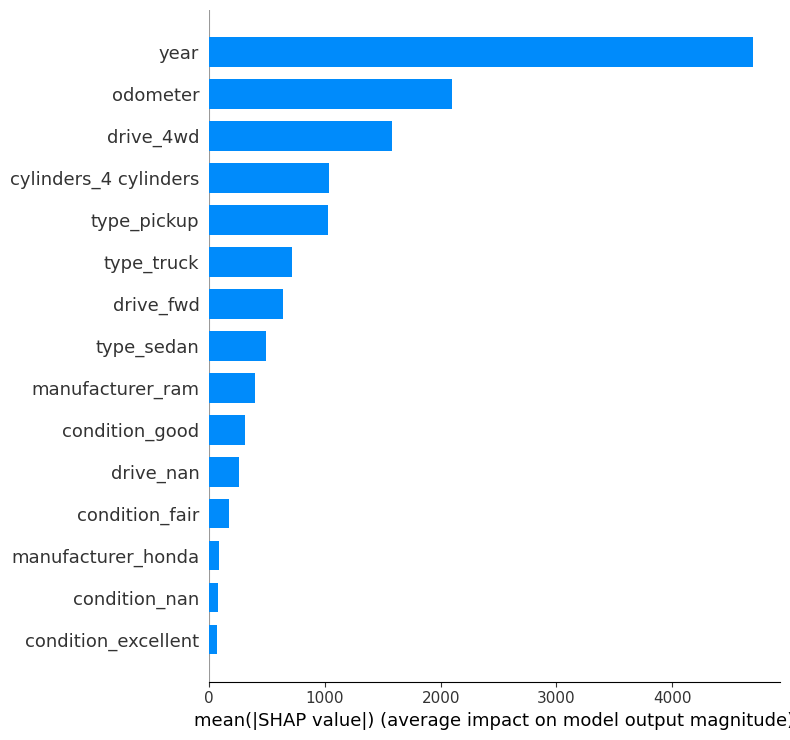

In [29]:
shap.summary_plot(shap_values, transformed_test_data, plot_type="bar")

In [30]:
fig = px.scatter(x=y_test, y=y_pred_cv, color_discrete_sequence=[COLORS[1]])
fig.layout.xaxis.title = "Wahrer Preis ($)"
fig.layout.yaxis.title = "Vorhergesagter Preis ($)"
fig.layout.width = 600
fig.layout.title = "Abweichung wahrer Preis und Preisprognose"
fig.show()

Text(0, 0.5, 'Preisprognose')

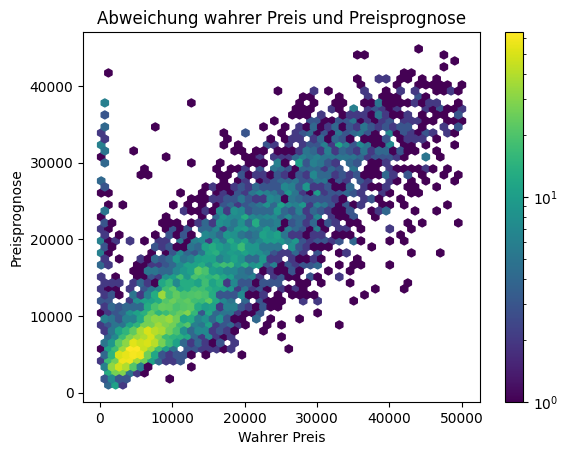

In [31]:
# plot prognosis vs true values in a different way
import matplotlib.pyplot as plt

plt.hexbin(y_test, y_pred, gridsize=50, bins="log")
plt.colorbar()
plt.title("Abweichung wahrer Preis und Preisprognose")
plt.xlabel("Wahrer Preis ($)")
plt.ylabel("Preisprognose ($)")

## Hyperparameter-Tuning

In [135]:
# defining a hyperparameter search for the previously defined pipeline

search_params = {
    "model__loss": ["squared_error", "absolute_error"],
    "model__learning_rate": [0.5, 0.25, 0.1, 0.05, 0.01, 0.001],
    "model__n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
    "model__max_depth": list(range(1, 10)),
    "model__min_samples_split": list(range(1, 10)),
    "model__min_samples_leaf": list(range(1, 10)),
    "model__max_features": list(range(2, X_train.shape[1])),
}
search = RandomizedSearchCV(
    pipe,
    search_params,
    n_jobs=4,
    cv=10,
    n_iter=20,
    verbose=1,
    scoring="neg_mean_absolute_error",
    random_state=2,
)
search.fit(X_train, y_train)
print("Best Score: ", search.best_score_)
print("Best Params: ", search.best_params_)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Score:  -3748.5389827737154
Best Params:  {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 8, 'model__max_features': 10, 'model__max_depth': 4, 'model__loss': 'absolute_error', 'model__learning_rate': 0.25}
